#Authors
**Author 1 (name and surname):** Sandra Burgos Artiguez

**Author 2 (name and surname):** Arántzazu López-Larraínzar Salazar

**Author 3 (name and surname):** Alan García Justel


# Preamble
Set the seed for experimental reproducibility:

In [ ]:
import tensorflow as tf
import skimage.io
import os
from tensorflow.keras.models import Sequential

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#Exercise 1
Mimicing the process seen in the lab session, load the CIFAR10 dataset from `tf.keras.datasets` and train a CNN which follows this architecture.


*   Convolutional layer with 32 filters of size 3$\times$3 and ReLU activation function.
*   Max pooling layer of size 2$\times$2.
*   Convolutional layer with 64 filters of size 3$\times$3 and ReLU activation function.
*   Max pooling layer of size 2$\times$2.
*   Convolutional layer with 64 filters of size 3$\times$3 and ReLU activation function.
*   Dense layer of 64 neurons and ReLU activation function.
*   A final dense layer with the number of target classes.

Train the model for 10 epochs with a batch size of 32 (default size in the `fit` function) and evaluate its performance in terms of accuracy in the test set. Use 20% of the training data as your validation set. Do not forget to explore the data before defining the neural network and training it.

In [ ]:
# TODO: write your code here
# libraries and methods
from tensorflow.keras.datasets import cifar10
import pathlib
from PIL import Image
from typing import Dict, Any, Optional

# save the images in the specified folders
def save_images(images, labels, folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        class_name = class_names[label[0]]
        img = Image.fromarray(image)
        img.save(folder / class_name / f"{i}.png")

# Training Dataset visualization
def show_train_split_samples(train_ds):
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
  plt.show()

# visualize training results
def visualize_history(history: Dict[str, Any], epochs: int) -> None:
  """Visualize the history information (accuracy, loss) given by the model."""
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 3))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss', marker='o')
  plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

def evaluate_model(model, history, test_ds: Optional[Any] = None):
  # Print train accuracy and loss
  print(f'Train Loss: {history.history["loss"][-1]}')
  print(f'Train Accuracy: {history.history["accuracy"][-1]}')
  # Print validation accuracy and loss
  print(f'Validation Loss: {history.history["val_loss"][-1]}')
  print(f'Validation Accuracy: {history.history["val_accuracy"][-1]}')
  # Evaluate the model
  if test_ds is not None:
    score = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {score[0]}")
    print(f"Test Accuracy: {score[1]}")

In [ ]:
# get the data and split it into train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# define the class names
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# create folder to save the images
data_dir = pathlib.Path("cifar10_dataset")
test_dir = pathlib.Path("cifar10_testset")

# create a single folder for each class
for class_name in class_names:
    (data_dir / class_name).mkdir(parents=True, exist_ok=True)
    (test_dir / class_name).mkdir(parents=True, exist_ok=True)

# save the images in their respective folder
save_images(x_train, y_train, data_dir)
save_images(x_test, y_test, test_dir)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print("There are", image_count, "images.")

There are 50000 images.


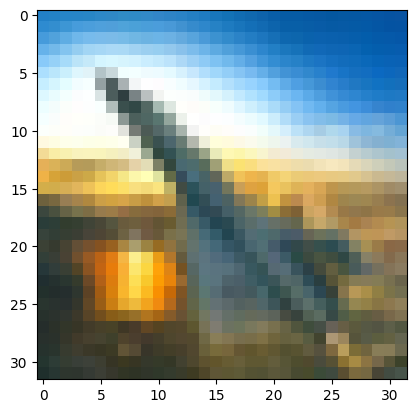

In [ ]:
airplane = list(data_dir.glob('airplane/*'))
img = skimage.io.imread(str(airplane[0]))
plt.imshow(img)

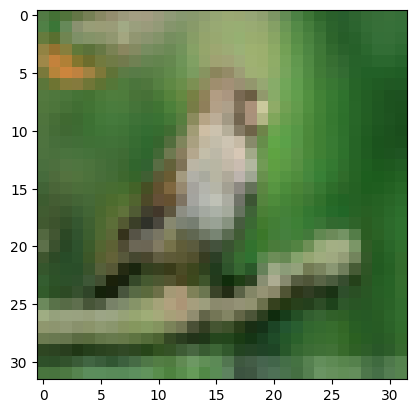

In [ ]:
bird = list(data_dir.glob('bird/*'))
img = skimage.io.imread(str(bird[0]))
plt.imshow(img)

In [ ]:
# parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

# use train-validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Important: don't shuffle the test data
)

# check class names of the training set
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Found 50000 files belonging to 10 classes.
Using 10000 files for validation.
Found 10000 files belonging to 10 classes.
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


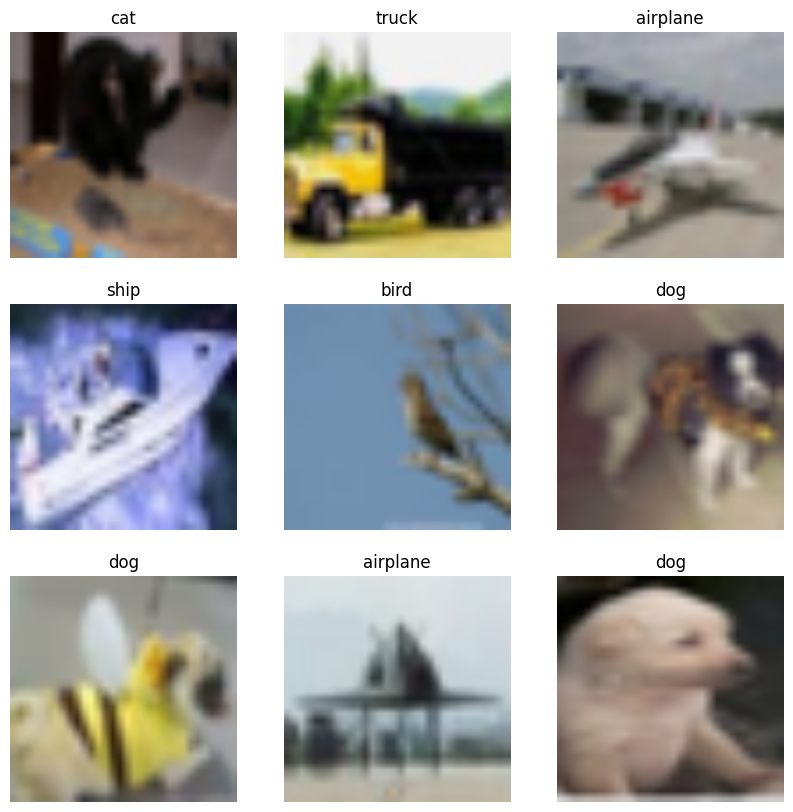

In [ ]:
show_train_split_samples(train_ds)

In [ ]:
# optimize the model pipeline by caching the dataset in memory
# (improving training speech)
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 10

In [ ]:
# model design
model = Sequential([
  layers.Input((img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

# compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       8,294,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,351,434 (31.86 MB)

 Trainable params: 8,351,434 (31.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fitting the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.3204 - loss: 1.9296 - val_accuracy: 0.4330 - val_loss: 1.5530
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4940 - loss: 1.3963 - val_accuracy: 0.5366 - val_loss: 1.2865
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5879 - loss: 1.1448 - val_accuracy: 0.5691 - val_loss: 1.2159
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6650 - loss: 0.9472 - val_accuracy: 0.5865 - val_loss: 1.2300
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7406 - loss: 0.7305 - val_accuracy: 0.6030 - val_loss: 1.2185
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8165 - loss: 0.5237 - val_accuracy: 0.6027 - val_loss: 1.3169
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8807 - loss: 0.3452 - val_accuracy: 0.5864 - val_loss: 1.7336
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9208 - loss: 0.2319 

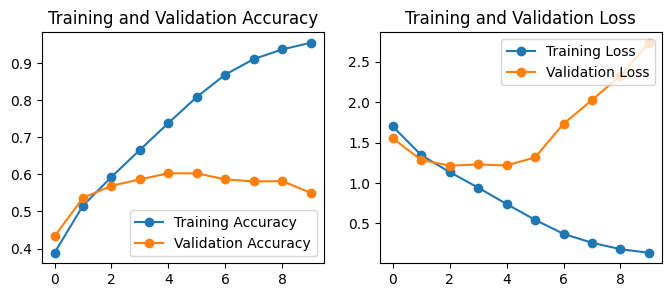

Train Loss: 0.13692280650138855
Train Accuracy: 0.954800009727478
Validation Loss: 2.736367702484131
Validation Accuracy: 0.5503000020980835
Test Loss: 2.784961223602295
Test Accuracy: 0.5408999919891357


In [ ]:
visualize_history(history, epochs)
evaluate_model(model, history, test_ds)

#Exercise 2
Design and implement your own CNN to improve over the baseline of Exercise 1. Use any of the techniques learned in class and document your experiments using a table. In this case, as the architectural choices can be very varied, we suggest to use an additional table just to describe your tested architectures. For example:
<table>
  <tr>
    <th>ID</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>0</td>
    <td>conv(32, 3x3)-mp(2x2)-conv(64, 3x3)-mp(2x2)-conv(64, 3x3)-fc(64)</td>
  </tr>
  <tr>
    <td>1</td>
    <td>...</td>
  </tr>
</table>

Using this table for architectures, you can use the experiments table in the following way:

<table>
  <tr>
    <th>ID</th>
    <th>Architecture</th>    
    <th>Epochs</th>
    <th>Learning rate</th>
    <th>Batch size</th>
    <th>L1</th>
    <th>L2</th>
    <th>Dropout</th>
    <th>Batch Normalization</th>
    <th>train acc</th>
    <th>test acc</th>
  </tr>
  <tr>
    <td>0</td>
    <td>0</td>    
    <td>10</td>
    <td>0.001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>No</td>
    <td>0.7807</td>
    <td>0.7057</td>
  </tr>  
</table>

Just as a reference, test accuracies between 0.80-0.90 are achievable with the techniques we saw in the lectures. The public leaderboards consulted recently show that the best accuracy obtained in the dataset is 0.9653.

**NOTE:** This table's columns only depict the most important hyperparameters and techniques we saw, from assignment 6. However, you can add any other column to show the effects of another technique or hyperparameter. Update the table as you consider.

## **Experiments**

### (Architecture 0) Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
# new model
model1 = Sequential([
  layers.Input((img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       8,294,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,351,434 (31.86 MB)

 Trainable params: 8,351,434 (31.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.2720 - loss: 2.0117 - val_accuracy: 0.4491 - val_loss: 1.5281
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.4404 - loss: 1.5456 - val_accuracy: 0.4934 - val_loss: 1.4052
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.4866 - loss: 1.4255 - val_accuracy: 0.5340 - val_loss: 1.3316
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5183 - loss: 1.3418 - val_accuracy: 0.5285 - val_loss: 1.3139
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5302 - loss: 1.3096 - val_accuracy: 0.5445 - val_loss: 1.2775
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5619 - loss: 1.2452 - val_accuracy: 0.5731 - val_loss: 1.2156
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5729 - loss: 1.2009 - val_accuracy: 0.5939 - val_loss: 1.1515
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5858 -

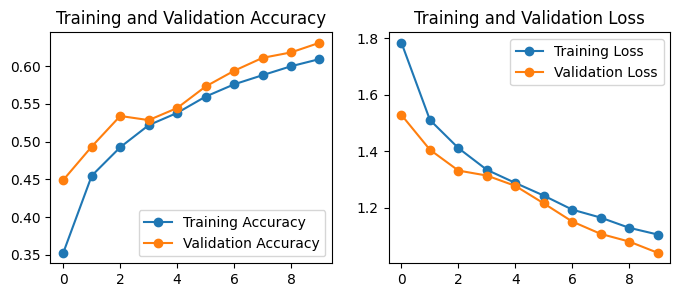

Train Loss: 1.105630874633789
Train Accuracy: 0.6094499826431274
Validation Loss: 1.0410877466201782
Validation Accuracy: 0.6310999989509583
Test Loss: 1.0280672311782837
Test Accuracy: 0.6310999989509583


In [ ]:
visualize_history(history, epochs)
evaluate_model(model1, history, test_ds)

### (Architecture 0) More data augmentation

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.2986 - loss: 1.9054 - val_accuracy: 0.4366 - val_loss: 1.5681
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4446 - loss: 1.5374 - val_accuracy: 0.4928 - val_loss: 1.4150
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4805 - loss: 1.4397 - val_accuracy: 0.5215 - val_loss: 1.3450
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5021 - loss: 1.3708 - val_accuracy: 0.5531 - val_loss: 1.2592
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5234 - loss: 1.3274 - val_accuracy: 0.5515 - val_loss: 1.2636
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5416 - loss: 1.2816 - val_accuracy: 0.5803 - val_loss: 1.1911
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5540 - loss: 1.2520 - val_accuracy: 0.5702 - val_loss: 1.2049
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5614 - loss: 1

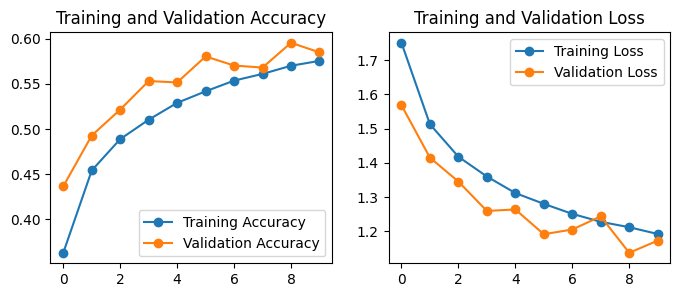

Train Loss: 1.1919034719467163
Train Accuracy: 0.5753750205039978
Validation Loss: 1.172361135482788
Validation Accuracy: 0.5848000049591064
Test Loss: 1.1632592678070068
Test Accuracy: 0.5856999754905701


In [ ]:
data_augmentation1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2)
  ]
)

model2 = Sequential([
  layers.Input((img_height, img_width, 3)),
  data_augmentation1,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

visualize_history(history, 10)
evaluate_model(model2, history, test_ds)

### (Architecture 0) Dropout

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.3303 - loss: 1.8391 - val_accuracy: 0.4903 - val_loss: 1.4081
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4912 - loss: 1.4116 - val_accuracy: 0.5307 - val_loss: 1.2994
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5330 - loss: 1.2969 - val_accuracy: 0.5782 - val_loss: 1.1846
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5548 - loss: 1.2411 - val_accuracy: 0.5925 - val_loss: 1.1442
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5770 - loss: 1.1852 - val_accuracy: 0.6017 - val_loss: 1.1130
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5955 - loss: 1.1453 - val_accuracy: 0.6106 - val_loss: 1.0930
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6040 - loss: 1.1094 - val_accuracy: 0.6158 - val_loss: 1.0722
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6156 - loss: 1

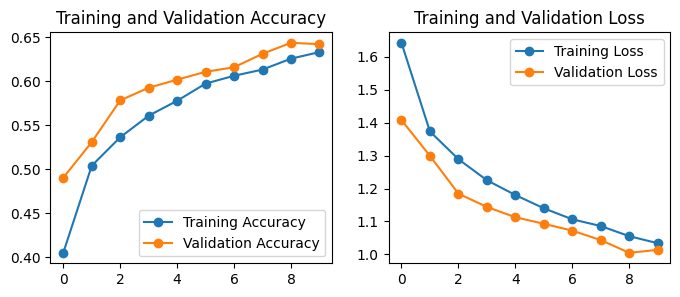

Train Loss: 1.033953309059143
Train Accuracy: 0.6330000162124634
Validation Loss: 1.0136494636535645
Validation Accuracy: 0.6420000195503235
Test Loss: 0.9931244254112244
Test Accuracy: 0.6452000141143799


In [ ]:
model3 = Sequential([
  layers.Input((img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

visualize_history(history, 10)
evaluate_model(model3, history, test_ds)

### (Architecture 0) Batch normalization

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.2351 - loss: 2.4142 - val_accuracy: 0.3701 - val_loss: 1.7546
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4110 - loss: 1.5479 - val_accuracy: 0.4804 - val_loss: 1.3876
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4807 - loss: 1.4081 - val_accuracy: 0.4853 - val_loss: 1.4204
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5303 - loss: 1.2955 - val_accuracy: 0.5720 - val_loss: 1.1759
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5493 - loss: 1.2487 - val_accuracy: 0.5673 - val_loss: 1.2004
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5688 - loss: 1.1996 - val_accuracy: 0.5405 - val_loss: 1.2689
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5772 - loss: 1.1715 - val_accuracy: 0.6007 - val_loss: 1.1037
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5817 -

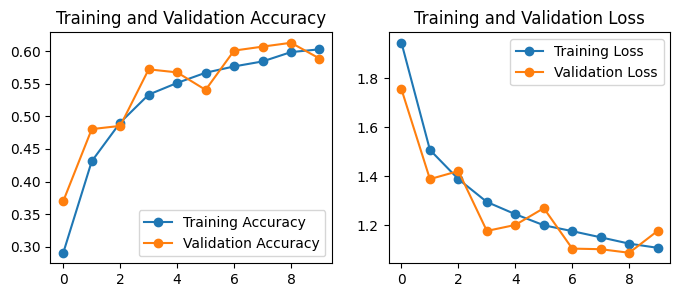

Train Loss: 1.1068559885025024
Train Accuracy: 0.602649986743927
Validation Loss: 1.1760715246200562
Validation Accuracy: 0.5885999798774719
Test Loss: 1.169416904449463
Test Accuracy: 0.5879999995231628


In [ ]:
model4 = Sequential([
  layers.Input((img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

visualize_history(history, 10)
evaluate_model(model4, history, test_ds)

### (Architecture 1) Adding more convolution layers

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3427 - loss: 1.7992 - val_accuracy: 0.5177 - val_loss: 1.3323
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5314 - loss: 1.3185 - val_accuracy: 0.6005 - val_loss: 1.1265
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5829 - loss: 1.1685 - val_accuracy: 0.6402 - val_loss: 1.0153
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6226 - loss: 1.0656 - val_accuracy: 0.6532 - val_loss: 0.9970
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6478 - loss: 1.0069 - val_accuracy: 0.6664 - val_loss: 0.9352
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6662 - loss: 0.9443 - val_accuracy: 0.6985 - val_loss: 0.8823
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6778 - loss: 0.9139 - val_accuracy: 0.7107 - val_loss: 0.8345
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6910 - loss: 0

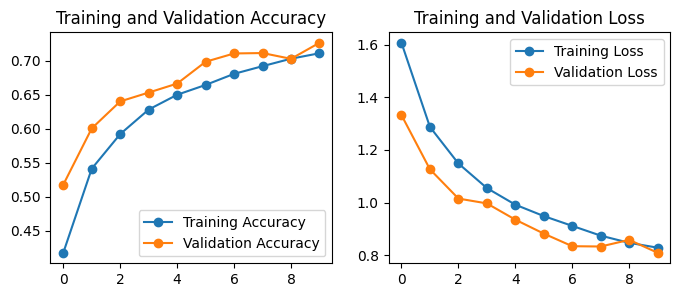

Train Loss: 0.8288321495056152
Train Accuracy: 0.7110000252723694
Validation Loss: 0.8095235824584961
Validation Accuracy: 0.7264000177383423
Test Loss: 0.8140377402305603
Test Accuracy: 0.7179999947547913


In [ ]:
model5 = Sequential([
  layers.Input((img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

visualize_history(history, 10)
evaluate_model(model5, history, test_ds)

### (Arquitecture 1) Learning rate 0.01

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.0963 - loss: 2.6391 - val_accuracy: 0.1019 - val_loss: 2.3038
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.0985 - loss: 2.3043 - val_accuracy: 0.0962 - val_loss: 2.3035
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.0986 - loss: 2.3039 - val_accuracy: 0.1004 - val_loss: 2.3032
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.0957 - loss: 2.3037 - val_accuracy: 0.0988 - val_loss: 2.3033
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1022 - loss: 2.3034 - val_accuracy: 0.0988 - val_loss: 2.3046
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1022 - loss: 2.3038 - val_accuracy: 0.0975 - val_loss: 2.3032
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.0973 - loss: 2.3040 - val_accuracy: 0.0988 - val_loss: 2.3044
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1011 - loss: 2

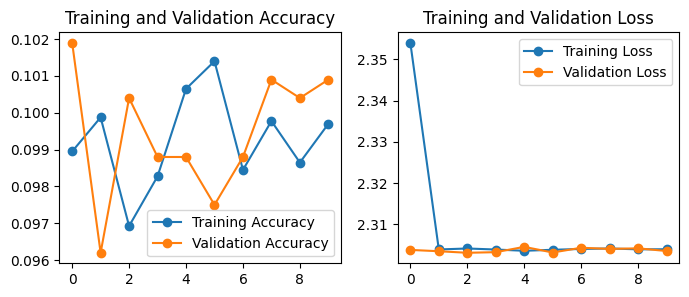

Train Loss: 2.304002523422241
Train Accuracy: 0.09969999641180038
Validation Loss: 2.3035786151885986
Validation Accuracy: 0.10090000182390213
Test Loss: 2.3041679859161377
Test Accuracy: 0.10000000149011612


In [ ]:
model6 = Sequential([
  layers.Input((img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model6.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

visualize_history(history, 10)
evaluate_model(model6, history, test_ds)

### (Arquitecture 1) Learning rate 0.0001

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3049 - loss: 1.8966 - val_accuracy: 0.4525 - val_loss: 1.5384
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4661 - loss: 1.4834 - val_accuracy: 0.5273 - val_loss: 1.3533
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5010 - loss: 1.3956 - val_accuracy: 0.5330 - val_loss: 1.3184
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5295 - loss: 1.3188 - val_accuracy: 0.5703 - val_loss: 1.2153
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5566 - loss: 1.2530 - val_accuracy: 0.5847 - val_loss: 1.1736
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5782 - loss: 1.1991 - val_accuracy: 0.5990 - val_loss: 1.1324
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5898 - loss: 1.1579 - val_accuracy: 0.6211 - val_loss: 1.0798
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6049 - loss: 1

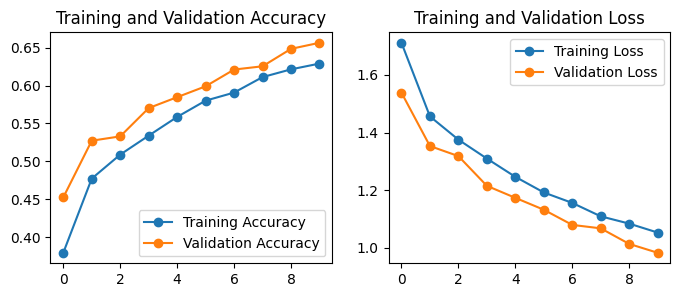

Train Loss: 1.0532095432281494
Train Accuracy: 0.628974974155426
Validation Loss: 0.9831136465072632
Validation Accuracy: 0.6564000248908997
Test Loss: 0.976067304611206
Test Accuracy: 0.6578999757766724


In [ ]:
model7 = Sequential([
  layers.Input((img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model7.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

visualize_history(history, 10)
evaluate_model(model7, history, test_ds)

### (Architecture 1) Epochs 15

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3307 - loss: 1.8113 - val_accuracy: 0.5278 - val_loss: 1.3140
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5179 - loss: 1.3378 - val_accuracy: 0.5835 - val_loss: 1.1805
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5714 - loss: 1.2140 - val_accuracy: 0.6379 - val_loss: 1.0386
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6027 - loss: 1.1205 - val_accuracy: 0.6359 - val_loss: 1.0334
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6231 - loss: 1.0573 - val_accuracy: 0.6782 - val_loss: 0.9169
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6445 - loss: 1.0013 - val_accuracy: 0.6793 - val_loss: 0.9236
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6594 - loss: 0.9639 - val_accuracy: 0.6836 - val_loss: 0.9109
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6733 - loss: 0

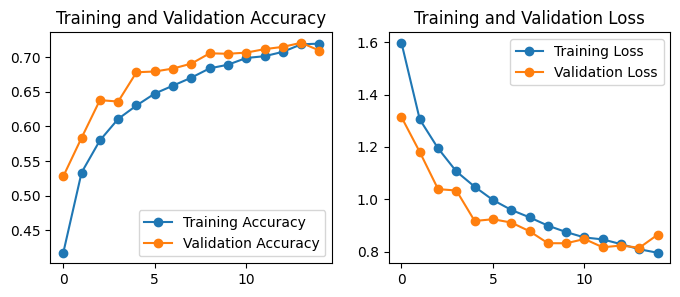

Train Loss: 0.7953832745552063
Train Accuracy: 0.7196000218391418
Validation Loss: 0.8645049929618835
Validation Accuracy: 0.7095000147819519
Test Loss: 0.8525968790054321
Test Accuracy: 0.7099999785423279


In [ ]:
model8 = Sequential([
  layers.Input((img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model8.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

visualize_history(history, 15)
evaluate_model(model8, history, test_ds)

### (Architecture 2) Adding more convolutional layers, epochs 15

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3007 - loss: 1.8897 - val_accuracy: 0.5080 - val_loss: 1.3613
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5078 - loss: 1.3730 - val_accuracy: 0.5857 - val_loss: 1.1640
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5670 - loss: 1.2113 - val_accuracy: 0.6240 - val_loss: 1.0340
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6108 - loss: 1.0993 - val_accuracy: 0.6630 - val_loss: 0.9492
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6334 - loss: 1.0299 - val_accuracy: 0.6874 - val_loss: 0.8853
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6483 - loss: 0.9870 - val_accuracy: 0.6814 - val_loss: 0.9100
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6723 - loss: 0.9298 - val_accuracy: 0.7127 - val_loss: 0.8300
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6853 - loss: 0

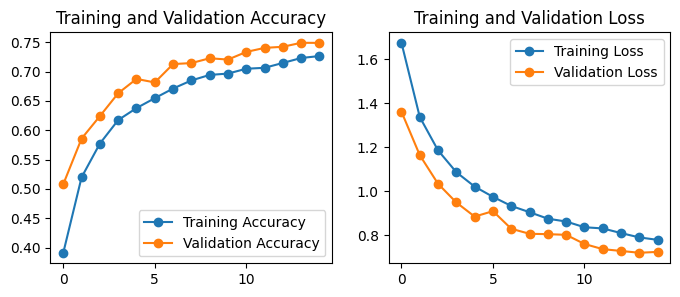

Train Loss: 0.7797000408172607
Train Accuracy: 0.7263749837875366
Validation Loss: 0.7251158952713013
Validation Accuracy: 0.7487999796867371
Test Loss: 0.7371060252189636
Test Accuracy: 0.7458999752998352


In [ ]:
model9 = Sequential([
  layers.Input((img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model9.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

visualize_history(history, 15)
evaluate_model(model9, history, test_ds)

## **Experimental Results**
Tested architectures:

<table>
  <tr>
    <th>ID</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>0</td>
    <td>conv(32, 3x3)-mp(2x2)-conv(64, 3x3)-mp(2x2)-conv(64, 3x3)-fc(64)</td>
  </tr>
  <tr>
    <td>1</td>
    <td>conv(32, 3x3)-mp(2x2)-conv(64, 3x3)-mp(2x2)-conv(64, 3x3)-mp(2x2)-conv(128, 3x3)-fc(64)</td>
  </tr>
  <tr>
    <td>2</td>
    <td>conv(32, 3x3)-mp(2x2)-conv(64, 3x3)-mp(2x2)-conv(64, 3x3)-mp(2x2)-conv(128, 3x3)-mp(2x2)-conv(128, 3x3)-mp(2x2)-fc(64)</td>
  </tr>
</table>

Results:
<table>
  <tr>
    <th>ID</th>
    <th>Architecture</th>    
    <th>Epochs</th>
    <th>Learning rate</th>
    <th>Batch size</th>
    <th>L1</th>
    <th>L2</th>
    <th>Dropout</th>
    <th>Batch Normalization</th>
    <th>Data Augmentation</th>
    <th>train acc</th>
    <th>val acc</th>
    <th>test acc</th>
  </tr>
  <tr>
    <td>0</td>
    <td>0</td>    
    <td>10</td>
    <td>0.001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>No</td>
    <td>No</td>
    <td>0.9548</td>
    <td>0.5503</td>
    <td>0.5409</td>
  </tr>  
  <tr>
    <td>1</td>
    <td>0</td>    
    <td>10</td>
    <td>0.001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>No</td>
    <td>Flip, Rotation, Zoom</td>
    <td>0.6094</td>
    <td>0.6311</td>
    <td>0.6311</td>
  </tr>
  <tr>
    <td>2</td>
    <td>0</td>    
    <td>10</td>
    <td>0.001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0</td>
    <td>No</td>
    <td>Flip, Rotation, Zoom, Brightness, Contrast</td>
    <td>0.5754</td>
    <td>0.5848</td>
    <td>0.5857</td>
  </tr>
  <tr>
    <td>3</td>
    <td>0</td>    
    <td>10</td>
    <td>0.001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0.2</td>
    <td>No</td>
    <td>Flip, Rotation, Zoom</td>
    <td>0.6330</td>
    <td>0.6420</td>
    <td>0.6452</td>
  </tr>
  <tr>
    <td>4</td>
    <td>0</td>    
    <td>10</td>
    <td>0.001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0.2</td>
    <td>Yes</td>
    <td>Flip, Rotation, Zoom</td>
    <td>0.6026</td>
    <td>0.5886</td>
    <td>0.5880</td>
  </tr>
  <tr>
    <td>5</td>
    <td>1</td>    
    <td>10</td>
    <td>0.001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0.2</td>
    <td>No</td>
    <td>Flip, Rotation, Zoom</td>
    <td>0.7110</td>
    <td>0.7264</td>
    <td>0.7180</td>
  </tr>
  <tr>
    <td>6</td>
    <td>1</td>    
    <td>10</td>
    <td>0.01</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0.2</td>
    <td>No</td>
    <td>Flip, Rotation, Zoom</td>
    <td>0.0997</td>
    <td>0.1009</td>
    <td>0.1000</td>
  </tr>
  <tr>
    <td>7</td>
    <td>1</td>    
    <td>10</td>
    <td>0.0001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0.2</td>
    <td>No</td>
    <td>Flip, Rotation, Zoom</td>
    <td>0.6290</td>
    <td>0.6564</td>
    <td>0.6580</td>
  </tr>
  <tr>
    <td>8</td>
    <td>1</td>    
    <td>15</td>
    <td>0.001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>v
    <td>0.2</td>
    <td>No</td>
    <td>Flip, Rotation, Zoom</td>
    <td>0.7196</td>
    <td>0.7095</td>
    <td>0.7100</td>
  </tr>
  <tr>
    <td>9</td>
    <td>2</td>    
    <td>15</td>
    <td>0.001</td>
    <td>32</td>
    <td>0</td>
    <td>0</td>
    <td>0.2</td>
    <td>No</td>
    <td>Flip, Rotation, Zoom</td>
    <td>0.7264</td>
    <td>0.7488</td>
    <td>0.7459</td>
  </tr>
</table>

#Exercise 3
Let us practice some **transfer learning**. Load and preprocess the flowers dataset as you saw in Lab 5. But instead of building your own CNN model, just fine-tune a pre-trained model. You can choose the model you want from [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications). You will have to surf the web to find out how a model is loaded with pre-trained weights from Imagenet. Look also carefully how the input images have to be preprocessed for the pre-trained network you selected. Afterwards, build an MLP classifier on top of the network, and train it using any of the regularization techniques seen in the lectures (remember to freeze the weights of the pre-trained network).

**NOTE:** The CNN we built for Lab 5 achieved ~71% of accuracy in the validation set. If you correctly perform the exercise, you can obtain ~93% of accuracy in the same validation set (or higher!).

In [ ]:
# Hyperparams
input_shape = (224, 224, 3)  # ResNet152 input size
batch_size = 32
lr = 1e-5
epochs = 10

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Dataset loaded with 3670 images
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Dataset classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
image_batch.shape: (32, 224, 224, 3)
labels_batch.shape: (32,)


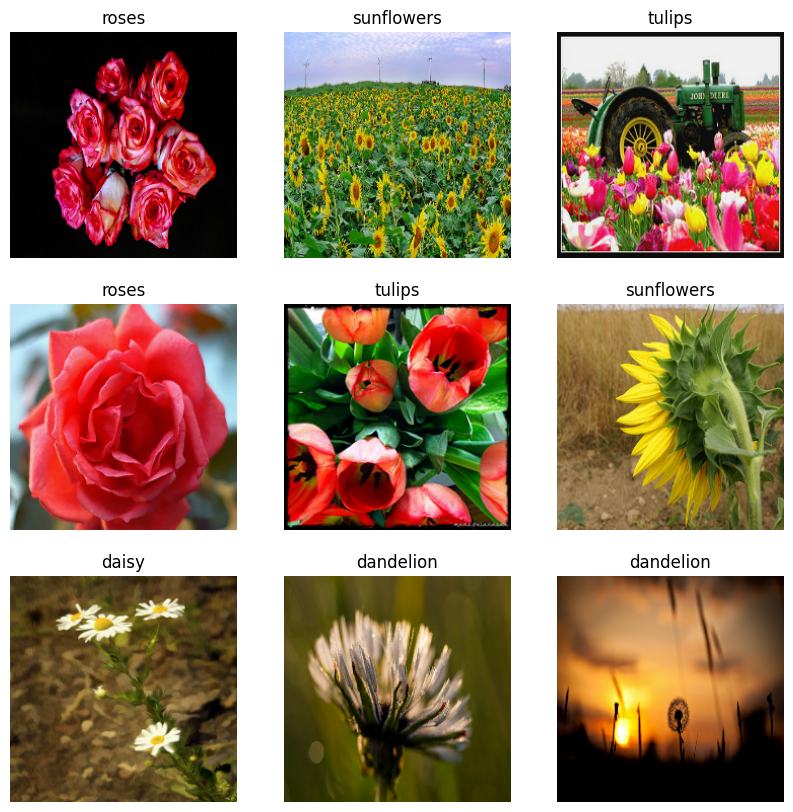

In [ ]:
# Load Dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir + "/flower_photos").with_suffix('')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Dataset loaded with {image_count} images")

# Train and Evaluation splits
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(input_shape[0], input_shape[1]),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(input_shape[0], input_shape[1]),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Dataset classes: {class_names}")

for image_batch, labels_batch in train_ds:
  print(f"image_batch.shape: {image_batch.shape}")
  print(f"labels_batch.shape: {labels_batch.shape}")
  break

show_train_split_samples(train_ds)

In [ ]:
# Load a pretrained ResNet152 on the ImageNet Dataset
base_model = tf.keras.applications.ResNet152(
    include_top=False,  # To exclude the already trained classification layer
    weights='imagenet',
    input_shape=input_shape
)
base_model.trainable = False  # Freeze the base model


# Build an MLP Classifier on top of the base model
inputs = keras.Input(shape=input_shape)
x = preprocess_input(inputs)                                        # Preprocess the input
x = base_model(x, training=False)                                   # Base model in inference mode
x = keras.layers.GlobalAveragePooling2D()(x)                        # Global average pooling
x = keras.layers.Dense(1024, activation='relu')(x)                  # Add a fully connected layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)  # Output layer

model = keras.models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [ ]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet152 (Functional)    │ (None, 7, 7, 2048)     │     58,370,944 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet152[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 1024)           │      2,098,176 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 5)              │          5,125 │ dense_24[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 60,474,245 (230.69 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [ ]:
model_history = model.fit( train_ds, validation_data=val_ds, epochs=epochs )

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 334ms/step - accuracy: 0.3036 - loss: 1.6906 - val_accuracy: 0.7425 - val_loss: 0.8781
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7856 - loss: 0.7525 - val_accuracy: 0.8433 - val_loss: 0.5814
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8375 - loss: 0.5243 - val_accuracy: 0.8760 - val_loss: 0.4635
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8749 - loss: 0.4207 - val_accuracy: 0.8883 - val_loss: 0.3983
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8940 - loss: 0.3581 - val_accuracy: 0.8965 - val_loss: 0.3566
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9131 - loss: 0.3054 - val_accuracy: 0.9046 - val_loss: 0.3279
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9264 - loss: 0.2679 - val_accuracy: 0.9114 - val_loss: 0.3055
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9329 - loss: 0.2432 - val_accuracy: 0.9114 -

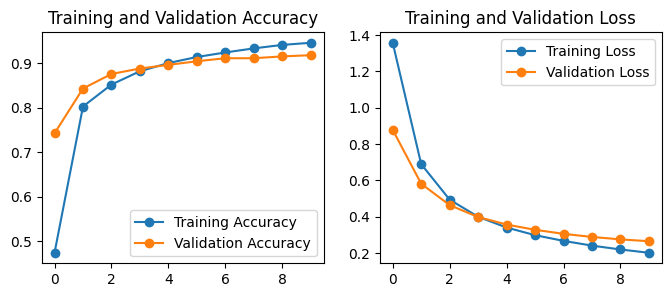

Train Loss: 0.20125144720077515
Train Accuracy: 0.946185290813446
Validation Loss: 0.2648986577987671
Validation Accuracy: 0.9182561039924622


In [ ]:
visualize_history(model_history, epochs)
evaluate_model(model, model_history)

With this setup and using a pretrained ResNet152 on the ImageNet dataset, we have managed to obtain an accuracy of ~95% on the validation dataset.

# Egela submission
Copy this notebook to your Drive and solve the proposed exercises there. Use the "share" button and make sure you configure such that "Anyone on the Internet with this link can view". Copy the link provided by the "share" menu and paste it here. Only one member of the team should submit the notebook

**Submission deadline:** Sunday, February 23 2025, 23:59h (CET)